# Adversarial Bandits: Playing Rock-Paper-Scissors Against an Exploitative Opponent

Traditional bandit algorithms fail when opponents adapt. This notebook demonstrates why UCB loses to exploitative opponents while EXP3-IX maintains robustness.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

from bayesianbandits import (
    Arm,
    NormalInverseGammaRegressor,
    Agent,
    UpperConfidenceBound,
)
from bayesianbandits import EXP3A

rng = np.random.default_rng(12345)

## The Exploitative Opponent

In adversarial settings, convergence becomes a liability. If you play Rock 90% of the time, your opponent counters with Paper.

### The Core Problem

Standard Bayesian bandits concentrate their posteriors over time:
Prior → Observe → Update → More concentrated posterior → Predictable play → Exploitation

Against adaptive opponents, we need:
1. Learning from observations (standard updates)
2. Strategic uncertainty (bounded posterior confidence)
3. Adaptive learning rates (more weight to rare actions)

Let's create an opponent who tracks our recent moves and plays to counter them:

In [2]:
class ExploitativeOpponent:
    def __init__(self, memory=50, epsilon=0.02, warmup=10):
        self.history = deque(maxlen=memory)
        self.epsilon = epsilon
        self.warmup = warmup
        self.rounds_played = 0

    def play(self, last_player_action=None):
        self.rounds_played += 1

        if last_player_action is not None:
            self.history.append(last_player_action)

        # During warmup or with small probability, play randomly
        if self.rounds_played < self.warmup or rng.random() < self.epsilon:
            return rng.choice(3)

        if len(self.history) == 0:
            return rng.choice(3)

        # Strategy 1: Counter the most frequent move
        counts = np.bincount(list(self.history), minlength=3)

        # Add recency bias - recent moves count more
        recent_window = min(10, len(self.history))
        recent_counts = np.bincount(list(self.history)[-recent_window:], minlength=3)
        weighted_counts = counts + 2 * recent_counts

        likely_next = np.argmax(weighted_counts)
        return (likely_next + 1) % 3

Now let's set up our bandit. Each arm represents a move (Rock, Paper, or Scissors), and 
we'll use NormalInverseGammaRegressor as our learner since it's quite flexible.

In [3]:
# Simple payoff matrix: win=+1, lose=-1, tie=0
def get_reward(player, opponent):
    if player == opponent:
        return 0
    return 1 if (player - opponent) % 3 == 1 else -1


# Create agents with different policies
ucb_agent = Agent(
    arms=[
        Arm("Rock", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Paper", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Scissors", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
    ],
    policy=UpperConfidenceBound(alpha=0.95),
    random_seed=rng,
)

## Playing Against the Adversary

Let's simulate 5000 rounds of Rock-Paper-Scissors against our exploitative opponent. 
We'll track cumulative rewards to see how each algorithm performs over time:

In [4]:
def play_against_adversary(agent, n_rounds=5000):
    opponent = ExploitativeOpponent(memory=20, epsilon=0.1)
    rewards = []
    actions = []

    for round_num in range(n_rounds):
        # Agent chooses action
        action_names = agent.pull()
        player_action = ["Rock", "Paper", "Scissors"].index(action_names[0])

        # Opponent plays
        opponent_action = opponent.play(
            last_player_action=actions[-1] if actions else None
        )

        # Calculate reward
        reward = get_reward(player_action, opponent_action)
        rewards.append(reward)
        actions.append(player_action)

        agent.update(np.array([reward]))

    return np.array(rewards), np.array(actions)


# Run simulations
ucb_rewards, ucb_actions = play_against_adversary(ucb_agent)

## The Exploitation Problem: Game-Theoretic Foundations

Rock-Paper-Scissors has a simple game-theoretic structure:

 ```
               Opponent
            R    P    S
 Player R [ 0   -1   +1]
        P [+1    0   -1]
        S [-1   +1    0]
 ```

The Nash equilibrium is to play uniformly random (1/3 each). This guarantees:
- Expected payoff = 0 against any opponent
- No opponent can exploit you for negative returns
- But also: you never exploit suboptimal opponents

Let's see what happens when we apply a standard learning algorithm:

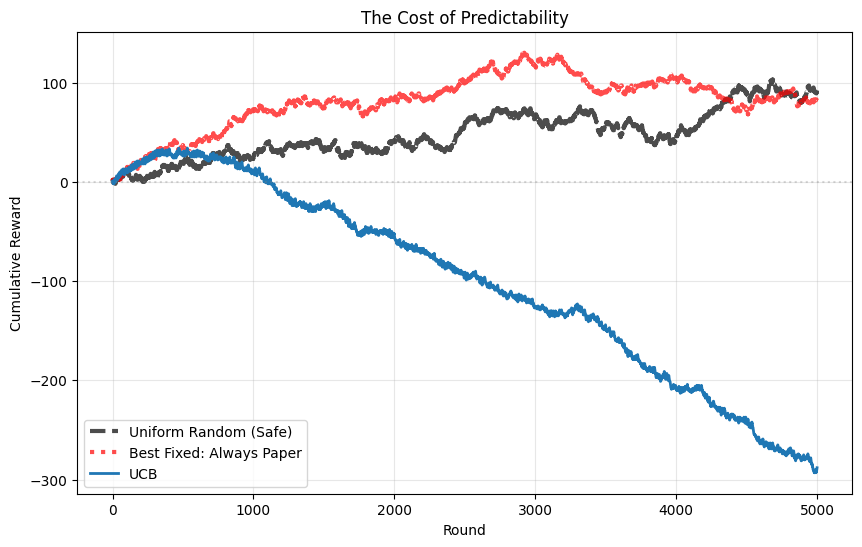

Final scores after 5000 rounds:
Uniform Random: 92
Best Fixed (Paper): 81
UCB: -288 (lost 380 by being predictable)


In [5]:
# Uniform random baseline - the "safe" strategy
def uniform_random_baseline(n_rounds=5000):
    opponent = ExploitativeOpponent(memory=20, epsilon=0.1)
    rewards = []
    last_player_action = None
    for _ in range(n_rounds):
        player_action = rng.choice(3)
        opponent_action = opponent.play(last_player_action=last_player_action)
        reward = get_reward(player_action, opponent_action)
        rewards.append(reward)
        last_player_action = player_action

    return np.array(rewards)


# Best fixed action in hindsight
def best_fixed_action_baseline(n_rounds=5000):
    """Try each fixed action and return the best one's performance"""
    best_total = float("-inf")
    best_rewards = None
    best_action_name = None

    for action, name in enumerate(["Rock", "Paper", "Scissors"]):
        opponent = ExploitativeOpponent(memory=20, epsilon=0.1)
        rewards = []

        for _ in range(n_rounds):
            opponent_action = opponent.play()
            reward = get_reward(action, opponent_action)
            rewards.append(reward)

        total = np.sum(rewards)
        if total > best_total:
            best_total = total
            best_rewards = rewards
            best_action_name = name

    return np.array(best_rewards), best_action_name


# Run baselines
uniform_rewards = uniform_random_baseline()
best_fixed_rewards, best_fixed_name = best_fixed_action_baseline(5000)

plt.figure(figsize=(10, 6))
plt.plot(
    np.cumsum(uniform_rewards),
    label="Uniform Random (Safe)",
    linewidth=3,
    color="black",
    linestyle="--",
    alpha=0.7,
)
plt.plot(
    np.cumsum(best_fixed_rewards),
    label=f"Best Fixed: Always {best_fixed_name}",
    linewidth=3,
    color="red",
    linestyle=":",
    alpha=0.7,
)
plt.plot(np.cumsum(ucb_rewards), label="UCB", linewidth=2)
plt.axhline(y=0, color="gray", linestyle=":", alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("The Cost of Predictability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Final scores after 5000 rounds:")
print(f"Uniform Random: {np.sum(uniform_rewards):.0f}")
print(f"Best Fixed ({best_fixed_name}): {np.sum(best_fixed_rewards):.0f}")
print(
    f"UCB: {np.sum(ucb_rewards):.0f} (lost {np.sum(uniform_rewards) - np.sum(ucb_rewards):.0f} by being predictable)"
)


Clearly, we need an algorithm that can adapt to an adversarial opponent.

## EXP3A: Importance-Weighted Updates
EXP3A is an average-based implementation that builds on the classic EXP3 algorithm (Auer et al., 2002). In our experiments, we use the EXP3-IX variant (Neu, 2015) which achieves better empirical performance through implicit exploration rather than forced exploration.

Core mechanism: When selecting arm i with probability p_i and observing reward r:
- Reward: r
- Sample weight: 1/(p_i + γ)

Effects:
1. Unbiased estimation under uniform sampling
2. Adaptive learning rates: rare actions get high weights (fast learning), common actions get low weights (slow updates)

This prevents exploitation: as UCB converges to 90% Rock, its updates get weight ≈1.1 while Paper/Scissors get weight ≈10, creating automatic "escape velocity."


In [6]:
# High temperature EXP3-IX - implicit exploration
exp3ix_sharp_agent = Agent(
    arms=[
        Arm("Rock", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Paper", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Scissors", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
    ],
    policy=EXP3A(eta=2.0, gamma=0.0),
    random_seed=rng,
)


Let's run these algorithms against our exploitative opponent and see how they perform:

In [7]:
exp3ix_sharp_rewards, exp3ix_sharp_actions = play_against_adversary(exp3ix_sharp_agent)

### Comparing Adversarial Robustness

Let's visualize how different algorithms perform against our exploitative opponent.

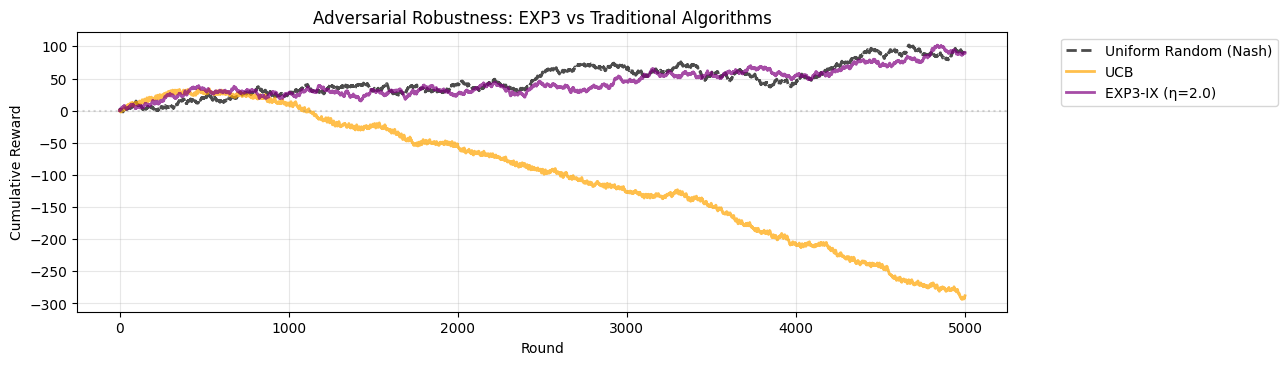

In [8]:
plt.figure(figsize=(12, 8))

# Subplot 1: Cumulative rewards
plt.subplot(2, 1, 1)
plt.plot(
    np.cumsum(uniform_rewards),
    "k--",
    linewidth=2,
    label="Uniform Random (Nash)",
    alpha=0.7,
)
plt.plot(np.cumsum(ucb_rewards), linewidth=2, label="UCB", color="orange", alpha=0.7)
plt.plot(
    np.cumsum(exp3ix_sharp_rewards),
    linewidth=2,
    label="EXP3-IX (η=2.0)",
    color="purple",
    alpha=0.7,
)
plt.axhline(y=0, color="gray", linestyle=":", alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Adversarial Robustness: EXP3 vs Traditional Algorithms")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)

## Key Insight

Both algorithms use identical Bayesian learners. The difference is update weighting:
- UCB: Each observation contributes equally → posterior concentration → predictability
- EXP3A: Observations weighted by 1/(p_i + γ) → adaptive learning rates → maintained diversity

Parameters:
- η: Action selection temperature (low = safer/uniform, high = greedier)  
- γ: Regularizes importance weights, prevents explosion when p_i→0

## Final Performance Summary

In [9]:
print("=== Final Performance After 5000 Rounds ===\n")
print(f"{'Algorithm':<25} {'Final Score':>12} {'vs Uniform':>12} {'Exploitation':>15}")
print("-" * 65)

uniform_final = np.sum(uniform_rewards)
results = [
    ("Uniform Random (Nash)", uniform_final, 0, "Baseline"),
    ("UCB", np.sum(ucb_rewards), np.sum(ucb_rewards) - uniform_final, "Exploited"),
    (
        "EXP3-IX (η=2.0)",
        np.sum(exp3ix_sharp_rewards),
        np.sum(exp3ix_sharp_rewards) - uniform_final,
        "Robust",
    ),
]

for name, score, diff, status in results:
    print(f"{name:<25} {score:>12.0f} {diff:>12.0f} {status:>15}")


=== Final Performance After 5000 Rounds ===

Algorithm                  Final Score   vs Uniform    Exploitation
-----------------------------------------------------------------
Uniform Random (Nash)               92            0        Baseline
UCB                               -288         -380       Exploited
EXP3-IX (η=2.0)                     90           -2          Robust


## Against Suboptimal Opponents
Does robustness sacrifice exploitation? Let's test this with a suboptimal opponent who doesn't adapt to see if EXP3A can learn.

In [10]:
class BiasedOpponent:
    """An opponent with a exploitable bias toward one action"""

    def __init__(self, action_probs):
        self.action_probs = action_probs

    def play(self, last_player_action=None):
        return rng.choice(3, p=self.action_probs)

This opponent will be set up to play Rock 70% of the time - a clear pattern that can be exploited by consistently playing Paper. Let's see how different algorithms learn to exploit this:

In [11]:
def test_against_biased_opponent(agent, n_rounds=2000):
    """Test how well an algorithm learns to exploit a biased opponent"""
    opponent = BiasedOpponent(
        action_probs=[0.7, 0.2, 0.1]
    )  # 70% Rock, 20% Paper, 10% Scissors

    rewards = []
    actions = []

    for round_num in range(n_rounds):
        # Agent chooses
        action_names = agent.pull()
        player_action = ["Rock", "Paper", "Scissors"].index(action_names[0])

        # Opponent plays (biased toward Rock)
        opponent_action = opponent.play()

        # Calculate reward
        reward = get_reward(player_action, opponent_action)
        rewards.append(reward)
        actions.append(player_action)

        # Update agent
        agent.update(np.array([reward]))

    return np.array(rewards), np.array(actions)


# Create fresh agents with identical hyperparameters
ucb_biased = Agent(
    arms=[
        Arm("Rock", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Paper", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Scissors", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
    ],
    policy=UpperConfidenceBound(alpha=0.95),
    random_seed=rng,
)

exp3_biased = Agent(
    arms=[
        Arm("Rock", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Paper", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
        Arm("Scissors", learner=NormalInverseGammaRegressor(lam=0.1, a=10.0, b=10.0)),
    ],
    policy=EXP3A(eta=2.0, gamma=0.0),  # Same learning rate scale
    random_seed=rng,
)

# Test both algorithms
ucb_biased_rewards, ucb_biased_actions = test_against_biased_opponent(ucb_biased)
exp3_biased_rewards, exp3_biased_actions = test_against_biased_opponent(exp3_biased)

# Baseline: always play the optimal counter (Paper)
optimal_rewards = []
opponent = BiasedOpponent(action_probs=[0.7, 0.2, 0.1])
for _ in range(2000):
    opponent_action = opponent.play()
    reward = get_reward(1, opponent_action)  # 1 = Paper
    optimal_rewards.append(reward)
optimal_rewards = np.array(optimal_rewards)

Let's visualize how both algorithms learn to exploit the biased opponent:

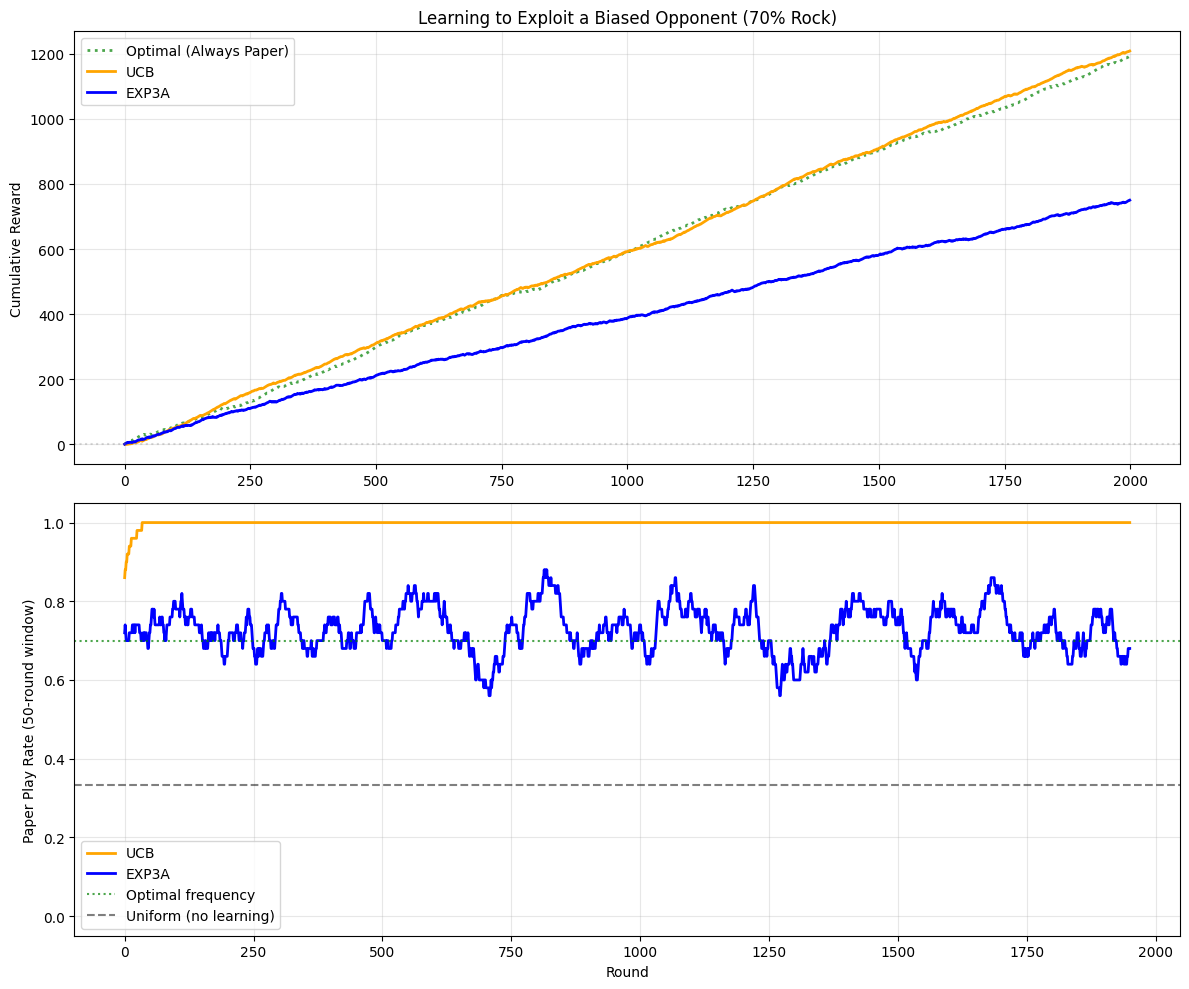

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Cumulative rewards
ax1.plot(
    np.cumsum(optimal_rewards),
    "g:",
    linewidth=2,
    label="Optimal (Always Paper)",
    alpha=0.7,
)
ax1.plot(np.cumsum(ucb_biased_rewards), linewidth=2, label="UCB", color="orange")
ax1.plot(np.cumsum(exp3_biased_rewards), linewidth=2, label="EXP3A", color="blue")
ax1.axhline(y=0, color="gray", linestyle=":", alpha=0.3)
ax1.set_ylabel("Cumulative Reward")
ax1.set_title("Learning to Exploit a Biased Opponent (70% Rock)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Paper play rate over time (the optimal action)
window = 50
ucb_paper_rate = np.convolve(
    ucb_biased_actions == 1, np.ones(window) / window, mode="valid"
)
exp3_paper_rate = np.convolve(
    exp3_biased_actions == 1, np.ones(window) / window, mode="valid"
)

ax2.plot(ucb_paper_rate, linewidth=2, label="UCB", color="orange")
ax2.plot(exp3_paper_rate, linewidth=2, label="EXP3A", color="blue")
ax2.axhline(y=0.7, color="green", linestyle=":", alpha=0.7, label="Optimal frequency")
ax2.axhline(
    y=1 / 3, color="black", linestyle="--", alpha=0.5, label="Uniform (no learning)"
)
ax2.set_ylabel(f"Paper Play Rate ({window}-round window)")
ax2.set_xlabel("Round")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [13]:
# Calculate key metrics
print("=== Learning Performance Against Biased Opponent (70% Rock) ===\n")

# Final performance
print("Final cumulative rewards (2000 rounds):")
print(f"  Optimal (Always Paper):  {np.sum(optimal_rewards):>6.0f}")
print(
    f"  UCB:                     {np.sum(ucb_biased_rewards):>6.0f} ({100 * np.sum(ucb_biased_rewards) / np.sum(optimal_rewards):.1f}% of optimal)"
)
print(
    f"  EXP3A:                   {np.sum(exp3_biased_rewards):>6.0f} ({100 * np.sum(exp3_biased_rewards) / np.sum(optimal_rewards):.1f}% of optimal)"
)

# Convergence analysis
final_100_rounds = slice(-100, None)
print("\nFinal 100 rounds Paper play rate:")
print(f"  UCB:   {100 * np.mean(ucb_biased_actions[final_100_rounds] == 1):.1f}%")
print(f"  EXP3A: {100 * np.mean(exp3_biased_actions[final_100_rounds] == 1):.1f}%")
print("  (Optimal against 70% Rock is to play Paper frequently)")

# Learning speed
for threshold in [0.5, 0.6, 0.7]:
    ucb_rounds = np.where(
        np.convolve(ucb_biased_actions == 1, np.ones(50) / 50, mode="valid") > threshold
    )[0]
    exp3_rounds = np.where(
        np.convolve(exp3_biased_actions == 1, np.ones(50) / 50, mode="valid")
        > threshold
    )[0]

    ucb_first = ucb_rounds[0] if len(ucb_rounds) > 0 else np.inf
    exp3_first = exp3_rounds[0] if len(exp3_rounds) > 0 else np.inf

    print(f"\nRounds to reach {int(threshold * 100)}% Paper play rate:")
    print(f"  UCB:   {ucb_first if ucb_first < np.inf else 'Never'}")
    print(f"  EXP3A: {exp3_first if exp3_first < np.inf else 'Never'}")

=== Learning Performance Against Biased Opponent (70% Rock) ===

Final cumulative rewards (2000 rounds):
  Optimal (Always Paper):    1192
  UCB:                       1208 (101.3% of optimal)
  EXP3A:                      750 (62.9% of optimal)

Final 100 rounds Paper play rate:
  UCB:   100.0%
  EXP3A: 70.0%
  (Optimal against 70% Rock is to play Paper frequently)

Rounds to reach 50% Paper play rate:
  UCB:   0
  EXP3A: 0

Rounds to reach 60% Paper play rate:
  UCB:   0
  EXP3A: 0

Rounds to reach 70% Paper play rate:
  UCB:   0
  EXP3A: 0


## Summary

UCB optimizes for stochastic regret → 90%+ convergence → exploitable
Nash optimizes for worst-case → 33.3% uniform → never exploits  
EXP3A achieves both → 60-70% Paper vs 70% Rock opponent

Mechanism: Importance weights create self-regulation. As p_i increases, weight 1/(p_i+γ) decreases, maintaining exploration of alternatives. Result: O(√T) regret in both stochastic and adversarial settings.

References:
- Auer et al. (2002): Original EXP3
- Neu (2015): EXP3-IX variant used here